<a href="https://colab.research.google.com/github/soheldatta17/Music-Recommendation-System-Model/blob/main/music_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="alert alert-block alert-danger">
Note: This notebook uses the python package lightfm which is not supported with Python 3.12!
To run this notebook, use Python 3.11.
</div>

Copyright © 2022 Gurobi Optimization, LLC

# A Music Recommendation System With Mathematical Optimization

A good song never gets old, except when it does.
Music streaming services like Spotify periodically provide their millions of users with curated music recommendations to keep them wanting to come back for more. It is important that these recommendations truly resonate with their users, while also introducing them to novelty that keeps their curiosity alive.

In this notebook, we will walk-through how to create a music recommendation system using a mixture of predictive and prescriptive analytics.
The predictive component foresees what users might be into based on their past music preferences, while the prescriptive component uses these predictions to  create an optimally diverse recommendation list.

**Goal**: Recommend new artists to users such that the artists are likeable and diverse.


The datasets used in this notebook are pre-processed from two Kaggle datasets:
- [Encrypted user data (Pichl, Zangerle and Specht, 2015)](https://www.kaggle.com/datasets/andrewmvd/spotify-playlists) with playlists created by [Spotify](https://open.spotify.com/) users, and
- [Artist data](https://www.kaggle.com/datasets/pieca111/music-artists-popularity) with musician demographics collected from [Musicbrainz](https://musicbrainz.org/) and [Last.fm](last.fm).

Pichl, Martin; Zangerle, Eva; Specht, Günther: "Towards a Context-Aware Music Recommendation Approach: What is Hidden in the Playlist Name?" in 15th IEEE International Conference on Data Mining Workshops (ICDM 2015), pp. 1360-1365, IEEE, Atlantic City, 2015.

## Load the data

To start, let's load the following packages for analyzing and visualizing the datasets.

In [1]:
%pip install gurobipy seaborn lightfm
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt
import seaborn as sns

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 27.5 MB/s eta 0:00:00
  Created wheel for lightfm: filename=lightfm-1.17-cp310-cp310-linux_x86_64.whl size=808328 sha256=b1a816f6ac8cee02faf35841a4cc0b6e33e773eb0f2c9ae026bed2e6e4d2f78b
  Stored in directory: /root/.cache/pip/wheels/4f/9b/7e/0b256f2168511d8fa4dae4fae0200fdbd729eb424a912ad636
Successfully built lightfm


We will first load the dataset with artist information. This dataset has 8,465 artists along with information on their  country of origin and the number of listeners they have on [Last.fm](https://www.last.fm/). Each artist is given an id from 0 through 8,465.

In [2]:
df_artist = pd.read_csv('https://raw.githubusercontent.com/Gurobi/modeling-examples/master/music_recommendation/artist_data.csv')
print(len(df_artist),"artists")
df_artist.head(20)

8465 artists


,artist_id,artist,country,listeners
0,0,Coldplay,United Kingdom,5381567
1,1,Radiohead,United Kingdom,4732528
2,2,Red Hot Chili Peppers,United States,4620835
3,3,Rihanna,United States,4558193
4,4,Eminem,United States,4517997
5,5,The Killers,United States,4428868
6,6,Kanye West,United States,4390502
7,7,Nirvana,United States,4272894
8,8,Muse,United Kingdom,4089612
9,9,Queen,United Kingdom,4023379


In [14]:
all_countries = list(df_artist['country'].unique())
all_countries.sort()
all_countries

['Algeria',
 'Argentina',
 'Australia',
 'Austria',
 'Bahamas',
 'Barbados',
 'Belarus',
 'Belgium',
 'Bermuda',
 'Bosnia and Herzegovina',
 'Brazil',
 'British Virgin Islands',
 'Cameroon',
 'Canada',
 'Cape Verde',
 'Chile',
 'Colombia',
 'Costa Rica',
 'Croatia',
 'Cuba',
 'Czech Republic',
 'Democratic Republic of the Congo',
 'Denmark',
 'Dominican Republic',
 'Egypt',
 'Estonia',
 'Ethiopia',
 'Faroe Islands',
 'Finland',
 'France',
 'Georgia',
 'Germany',
 'Ghana',
 'Greece',
 'Grenada',
 'Guatemala',
 'Guinea',
 'Haiti',
 'Hungary',
 'Iceland',
 'India',
 'Iraq',
 'Ireland',
 'Israel',
 'Italy',
 'Ivory Coast',
 'Jamaica',
 'Japan',
 'Jersey',
 'Kazakhstan',
 'Kenya',
 'Latvia',
 'Lebanon',
 'Liechtenstein',
 'Lithuania',
 'Malaysia',
 'Mali',
 'Malta',
 'Mexico',
 'Moldova',
 'Monaco',
 'Morocco',
 'Nepal',
 'Netherlands',
 'New Zealand',
 'Nicaragua',
 'Niger',
 'Nigeria',
 'Norway',
 'Pakistan',
 'Panama',
 'Peru',
 'Philippines',
 'Poland',
 'Portugal',
 'Romania',
 'Russia

In [15]:
for i in all_countries:
  print(f"{df_artist[df_artist['country'] == i].shape[0]} Artists are from {i}")

1 Artists are from Algeria
70 Artists are from Argentina
176 Artists are from Australia
23 Artists are from Austria
1 Artists are from Bahamas
4 Artists are from Barbados
1 Artists are from Belarus
49 Artists are from Belgium
2 Artists are from Bermuda
2 Artists are from Bosnia and Herzegovina
54 Artists are from Brazil
1 Artists are from British Virgin Islands
2 Artists are from Cameroon
277 Artists are from Canada
2 Artists are from Cape Verde
16 Artists are from Chile
23 Artists are from Colombia
1 Artists are from Costa Rica
6 Artists are from Croatia
19 Artists are from Cuba
5 Artists are from Czech Republic
2 Artists are from Democratic Republic of the Congo
53 Artists are from Denmark
5 Artists are from Dominican Republic
2 Artists are from Egypt
4 Artists are from Estonia
1 Artists are from Ethiopia
3 Artists are from Faroe Islands
71 Artists are from Finland
215 Artists are from France
2 Artists are from Georgia
244 Artists are from Germany
1 Artists are from Ghana
6 Artists a

Let us take a look at the distribution of the number of listeners for the most popular 2,000 artists.

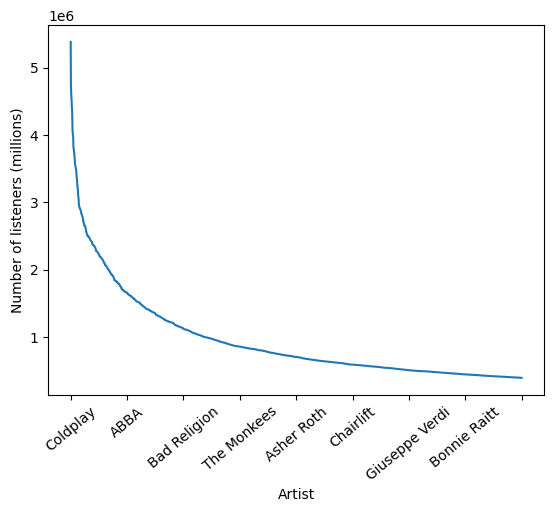

In [16]:
df_artist.set_index('artist')['listeners'].head(2000).plot(rot=40)
plt.xlabel('Artist')
plt.ylabel('Number of listeners (millions)')
plt.show()

Where are these artists from? Let us visualize the number of artists from each country. There are 102 countries in this dataset, and the three most common places of origin are: the United States, the United Kingdom and Sweden.

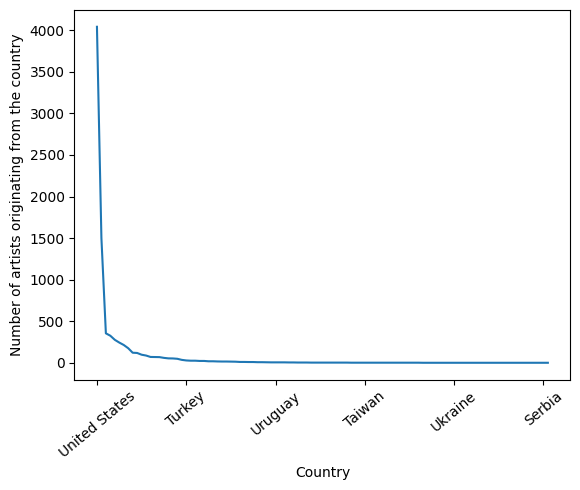

,country,count
0,United States,4041
1,United Kingdom,1500
2,Sweden,355
3,Spain,326
4,Canada,277
...,...,...
97,Saint Vincent and The Grenadines,1
98,Samoa,1
99,Guinea,1
100,Serbia,1


In [17]:
df_country = df_artist.groupby('country')['country'].count().sort_values(ascending = False).reset_index(name="count")
df_country.set_index('country')['count'].plot(rot=40) #Select countries with at least 100 artists from there
plt.xlabel('Country')
plt.ylabel('Number of artists originating from the country')
plt.show()
df_country

Next, load the dataset with user information on playlists created by each of the 1,306 users. A playlist is a set of music tracks from various artists. This dataset is important to understand a user's preference over the artists. The number of tracks from an artist that appear in a user's playlist is a good measure of how much a user likes that artist.

In [18]:
df_playlist = pd.read_csv('https://raw.githubusercontent.com/Gurobi/modeling-examples/master/music_recommendation/user_playlist_data.csv')
print(df_playlist['user_id'].nunique(),"users")
df_playlist.head(50)

1306 users


,user_id,artist_id,artist,track,playlist
0,785,622,Elvis Costello,(The Angels Wanna Wear My) Red Shoes,HARD ROCK 2010
1,785,622,Elvis Costello,Alison,HARD ROCK 2010
2,785,622,Elvis Costello,Tramp The Dirt Down,HARD ROCK 2010
3,993,622,Elvis Costello,Don't Let Me Be Misunderstood,Everything at once
4,487,622,Elvis Costello,Alison,Home
5,300,622,Elvis Costello,Beautiful,Ángeles
6,155,622,Elvis Costello,Watching The Detectives - Single Version,Vergaarbaak
7,155,622,Elvis Costello,She,Voorbeschouwing
8,317,622,Elvis Costello,Deep Dark Truthful Mirror,We Are Hunted Paramore Chart Jan 12
9,697,622,Elvis Costello,Alison,All Time Great Songs


## Train the prediction model using collaborative filtering

We now train a prediction model to learn the users' preferences of artists using **collaborative filtering**, a popular method commonly used for product recommendations. The idea is to user the collaborative information of all other users to predict the preference of one user.

To achieve collaborative filtering on this user-artist dataset, will use **matrix factorization**. Here, the key input is an $n \times m$ matrix with rows comprising  $n$ users and columns comprising $m$ artists. An entry in the matrix denotes how much that user likes that artist- measured by the frequency of artist occurrence in their playlists. This matrix is factorized into two matrices with dimensions $n \times d$ and $d \times m$, where $d$ is the number of hidden features. The larger the number of features $d$, the more complex and nuanced the model is, albeit running the risk of over-fitting. See [here](https://towardsdatascience.com/intro-to-recommender-system-collaborative-filtering-64a238194a26) to read more about collaborative filtering.


We will use [lightfm](https://github.com/lyst/lightfm) for matrix factorization as follows.

In [19]:
import lightfm
from lightfm import LightFM, cross_validation
from lightfm.evaluation import auc_score

Create the input matrix for matrix factorization using the frequency of occurrence of artists in each user's playlists.

In [20]:
# Dataframe that stores the frequency of artists as they appear in users' playlists
df_freq = df_playlist.groupby(['user_id', 'artist']).agg('size').reset_index().rename(columns={0:'freq'})[['user_id', 'artist', 'freq']].sort_values(['freq'], ascending=False)
df_freq = df_freq.merge(df_artist[['artist_id','artist']], left_on='artist', right_on='artist')

# Input matrix
input_matrix = df_freq.groupby(['user_id', 'artist_id'])['freq'].sum().unstack().reset_index().fillna(0).set_index('user_id')

# Dictionary to track the artist id for each artist name
artists_dict ={(df_artist.loc[i,'artist_id']): df_artist.loc[i,'artist'] for i in range(df_artist.shape[0])}
df_freq.head()

,user_id,artist,freq,artist_id
0,701,The Rolling Stones,667,13
1,1152,Bad Religion,659,500
2,328,The Rolling Stones,658,13
3,469,Andrés Calamaro,594,3118
4,584,Pet Shop Boys,503,441


Before training the prediction model, the dataset is randomly split into a training set (80%) and a testing set (20%) to evaluate the fit. The quality of the fit is measured by the *area under an ROC curve (AUC)* metric. This is a measure of the likelihood that a preferred item by a user is ranked higher than a random item. The closer it is to 1, the better the fit. See [here](https://flowthytensor.medium.com/some-metrics-to-evaluate-recommendation-systems-9e0cf0c8b6cf) to read more about the AUC score.

The parameters for the model are the number of components (or features), the loss function, number of epochs, among others. The values set for these parameters are shown below, but try other values to observe their effect on the performance.

In [21]:
### Train-Test split
from scipy import sparse
x = sparse.csr_matrix(input_matrix.values)
train, test = lightfm.cross_validation.random_train_test_split(x, test_percentage=0.2, random_state=None)

### Train the Matrix Factorization Model
model = LightFM(no_components=50, loss='warp')
model.fit(x, epochs=30, num_threads = 4)

train_auc = auc_score(model, train, num_threads=4).mean()
test_auc = auc_score(model, test, train_interactions=train, num_threads=4).mean()
print('Train AUC: %f, test AUC: %f'%(train_auc,test_auc))

Train AUC: 0.984143, test AUC: 0.985645


## Select a user

The prediction model has been trained. For the rest of the notebook, we focus on recommending artists for one user. First, select a user and retrieve their learned preference scores (a value between 0 and 1) among the artists. The higher the preference score, the greater their preference for that user according to the trained model.

To select a user, use the dropdown at the bottom of this cell to choose a user id from 0 (default) through 1,305.

In [22]:
from __future__ import print_function
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

def get_user_preference(x):
    # Create a dictionary that stores the preference for each artist as a number between 0 and 1
    global preference, df_pref
    preference = pd.Series(model.predict(x, np.arange(input_matrix.shape[1]))).to_dict()
    lower_score = min(preference.values())
    highest_score = max(preference.values())
    preference = {artists_dict[i]:(preference[i]-lower_score)/(highest_score-lower_score) for i in preference}

    # Print the known likes of the user
    known_items = list(pd.Series(input_matrix.loc[x,:][input_matrix.loc[x,:] > 0].index).sort_values(ascending=False))
    known_items = list(pd.Series(known_items).apply(lambda x: artists_dict[x]))
    print("Top 20 artists this user already likes:\n",known_items[:20])

    # Print the predicted preference scores of the user
    df_pref = pd.DataFrame.from_records([(k, v) for k, v in preference.items()], columns =['artist', 'preference'])
    df_pref = df_artist.merge(df_pref,left_on='artist',right_on='artist').sort_values(by = 'preference',ascending=False)
    print("\nPredicted preferences:")

n_users = df_playlist['user_id'].nunique()
print("Select a user id from 0 through %i."%(n_users-1))
interact(get_user_preference, x=list(range(n_users)))
df_pref.head(30)

Select a user id from 0 through 1305.


interactive(children=(Dropdown(description='x', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

,artist_id,artist,country,listeners,preference
90,90,Kelly Clarkson,United States,2425837,1.000000
3,3,Rihanna,United States,4558193,0.968858
52,52,Christina Aguilera,United States,2788515,0.952803
342,342,Backstreet Boys,United States,1413894,0.947504
78,78,P!nk,United States,2495211,0.945410
322,322,R. Kelly,United States,1456472,0.943413
269,269,Whitney Houston,United States,1607022,0.942691
62,62,Usher,United States,2650020,0.936276
109,109,Alicia Keys,United States,2325048,0.931606
16,16,Katy Perry,United States,3733134,0.925718


For our chosen user, we have the predicted preference scores for the artists. Looking at the most preferred artists, several of the artists are massively popular. For example, for user 0, their 30 most preferred artists have more than a million listeners on average.

In [23]:
print("The top 30 artists have %i listeners on average."% int(df_pref[['listeners']].head(30).sum()/30))

The top 30 artists have 1953767 listeners on average.


In [24]:
import gurobipy as gp
from gurobipy import GRB

artists = sorted(preference.keys(),reverse=True,key=lambda x : preference[x])[:1000]  # Set of the most preferred 1000 artists
popularity = df_artist.groupby('artist')['listeners'].apply(float).to_dict() # Popularity of each artist
P_max = 500000
N = 30

m = gp.Model("Recommend artists") # this defines the model that we'll add to as we finish the formulation

Restricted license - for non-production use only - expires 2026-11-23


### Decision variables

The key data structure that stores the solution of an optimization problem is a *decision variable*. In our model, we want to store whether or not an artist is chosen to be included in the solution. Hence, we define the following *binary decision variable* for each artist $a$ to represent a **yes** or **no** decision we want to make. This is modeled as $x_a = 1$  if artist $a$  is chosen; and $x_a = 0$  otherwise.


Dictionaries are a good way to store the decision variables. We can add the variables either by looping through each artist, or all at once (as shown in the commented code below).

In [25]:
x = {}
for a in artists:
    x[a] = m.addVar(vtype=GRB.BINARY)
# x = m.addVars(artists,vtype=GRB.BINARY)

In [26]:
m.setObjective(sum(x[a]*preference[a] for a in artists), GRB.MAXIMIZE)
m.ModelSense = GRB.MAXIMIZE

In [27]:
popularity_constraints = m.addConstr(sum(x[a]*popularity[a] for a in artists) <= P_max*N)

In [28]:
n_artists_constraints = m.addConstr(sum(x[a] for a in artists) == N)

In [29]:
m.optimize()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 2 rows, 1000 columns and 2000 nonzeros
Model fingerprint: 0xab1003ca
Variable types: 0 continuous, 1000 integer (1000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+06]
  Objective range  [6e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+01, 2e+07]
Presolve time: 0.00s
Presolved: 2 rows, 1000 columns, 2000 nonzeros
Variable types: 0 continuous, 1000 integer (1000 binary)
Found heuristic solution: objective 18.0671185

Root relaxation: objective 2.335492e+01, 4 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   23.35492    0    2   18.06712  

The optimizer solved the model. Let us now retrieve the optimal solution. The value of variable $x_a$ can be retrieved using the code "x[a].X"; artist $a$ is chosen if x[a].X is $1$.

The following code stores the solution as a Pandas dataframe.

In [30]:
chosen_artists = [a for a in artists if x[a].X > .99]
dict_artist_country = dict(zip(df_artist.artist, df_artist.country))

df_chosen_artists = pd.DataFrame({'artists':chosen_artists, 'popularity':[popularity[i] for i in chosen_artists], 'preference':[preference[i] for i in chosen_artists], 'country':[dict_artist_country[i] for i in chosen_artists]})
print("Artists chosen:"%(chosen_artists))
df_chosen_artists

Artists chosen:


,artists,popularity,preference,country
0,Bastille,1054768.0,0.921015,United Kingdom
1,Clean Bandit,842709.0,0.872506,United Kingdom
2,Vance Joy,768178.0,0.865431,Australia
3,Hozier,890930.0,0.855643,Ireland
4,Icona Pop,780473.0,0.848459,Sweden
5,Capital Cities,719398.0,0.846752,United States
6,Mr. Probz,500472.0,0.812645,Netherlands
7,Milky Chance,579484.0,0.807261,Germany
8,John Newman,497860.0,0.806627,United Kingdom
9,Kodaline,569990.0,0.804355,Ireland


We can observe that the artists are overall more *niche* than just picking the top 30 preferred artists. While this recommendation is diverse in terms of popularity, the artists are predominantly from a set of few countries. Can international diversity be infused into the recommendation?

In [31]:
artists_in_country = df_artist[df_artist['artist'].isin(artists)].groupby('country')['artist'].apply(list).to_dict() # the set of artists from each country
countries = artists_in_country.keys() # The set of all countries
C_min = 20 # A number between 0 and N

### Decision variables

To track whether a country is represented or not, the following binary decision variable is created for each country $c$. This is modeled as $y_c = 1$  if country $c$  is represented; and $y_c = 0$  otherwise.

The variables are added to the model. Note that we are adding it to the same model that we used earlier.

In [32]:
y = m.addVars(countries, vtype=GRB.BINARY)

In [33]:
country_defining_constraints = m.addConstrs((y[c] <= sum(x[a] for a in artists_in_country[c])) for c in countries)

In [34]:
country_limit_constraints = m.addConstr(sum(y[c] for c in artists_in_country) >= C_min)
m.optimize()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 33 rows, 1030 columns and 3060 nonzeros
Model fingerprint: 0x9d6208f3
Variable types: 0 continuous, 1030 integer (1030 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+06]
  Objective range  [6e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+01, 2e+07]

MIP start from previous solve did not produce a new incumbent solution

Presolve removed 8 rows and 8 columns
Presolve time: 0.01s
Presolved: 25 rows, 1022 columns, 3044 nonzeros
Variable types: 0 continuous, 1022 integer (1022 binary)

Root relaxation: objective 2.274074e+01, 41 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd  

Visualize the solution.

30 artists in 20 countries chosen.
Represented countries: ['Australia', 'Austria', 'Belgium', 'Canada', 'Chile', 'Denmark', 'Estonia', 'France', 'Germany', 'Iceland', 'Ireland', 'Malaysia', 'Mexico', 'Netherlands', 'New Zealand', 'Norway', 'Spain', 'Sweden', 'United Kingdom', 'United States']


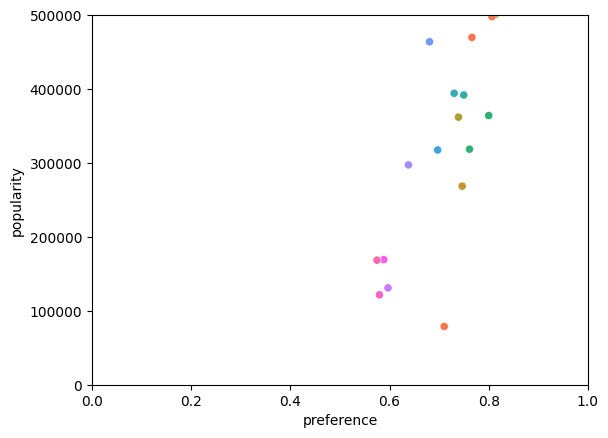

,artists,popularity,preference,country
0,Of Monsters and Men,1239043.0,0.937747,Iceland
1,Bastille,1054768.0,0.921015,United Kingdom
2,Clean Bandit,842709.0,0.872506,United Kingdom
3,Vance Joy,768178.0,0.865431,Australia
4,Icona Pop,780473.0,0.848459,Sweden
5,Capital Cities,719398.0,0.846752,United States
6,Mr. Probz,500472.0,0.812645,Netherlands
7,Milky Chance,579484.0,0.807261,Germany
8,John Newman,497860.0,0.806627,United Kingdom
9,Kodaline,569990.0,0.804355,Ireland


In [35]:
chosen_artists = [a for a in artists if x[a].X > .99]
chosen_countries = [c for c in artists_in_country if y[c].x > 0.99]
print("%i artists in %i countries chosen."%(len(chosen_artists),len(chosen_countries)))
print("Represented countries:",chosen_countries)

df_chosen_artists = pd.DataFrame({'artists':chosen_artists, 'popularity':[popularity[i] for i in chosen_artists], 'preference':[preference[i] for i in chosen_artists], 'country':[dict_artist_country[i] for i in chosen_artists]})
sns.scatterplot(data=df_chosen_artists, x="preference", y="popularity", hue="country", legend = False)
plt.xlim(0, 1)
plt.ylim(0, 500000)
plt.show()
df_chosen_artists

We can definitely see more international diversity among the chosen set of artists.

While this notebook walked through how to build an optimization model piece-by-piece, the following code contains the overall optimization model. You can input different parameter values for $P_{max}$ (maximum limit on the average popularity), $N$ (number of chosen artists ) and $C_{min}$ (minimum limit on the number of countries to be represented) and see how the optimal solution changes. The value of $P_{max}$ can be controlled using the slider below the cell.

What happens if $P_{max}$ is too low? Is there a trade-off between popularity and likeability? Can you find a solution where all the artists are uniquely different countries?

In [36]:
def solve(x):
    # Input parameters for artist selection
    P_max = x # maximumum limit on the average popularity
    N = 30 # number of chosen artists
    C_min = 30 # minimum limit on the number of countries to be represented

    #Initiate the model
    m = gp.Model("Playlisting")

    # Define the variables
    x = m.addVars(artists,vtype=GRB.BINARY)
    y = m.addVars(countries, vtype=GRB.BINARY)

    # Define the objective
    m.setObjective(sum(x[a]*preference[a] for a in artists), GRB.MAXIMIZE)
    m.ModelSense = GRB.MAXIMIZE

    # Add the constraitns
    m.addConstr(sum(x[a]*popularity[a] for a in artists) <= P_max*N) # Sets a maximum limit on the average popularity
    m.addConstr(sum(x[a] for a in artists) == N) # Selects exactly N artists

    m.addConstrs((y[c] <= sum(x[a] for a in artists_in_country[c])) for c in countries) # Selects a country only if an artist from that country is chosen
    m.addConstr(sum(y[c] for c in artists_in_country) >= C_min) # Sets a minimum limit on the number of countries represented

    m.setParam('OutputFlag', 0) # Suppress the output
    m.optimize() # Run the optimization of the model

    if m.status != 2:
        print("\n The problem is infeasible. There is no solution that satisfies all the constraints.")
        print("Try increasing the maximum popularity limit, or decreasing the minimum number of countries to be represented.")
        return

    chosen_artists = [a for a in artists if x[a].X > .99] # Chosen set of artists
    chosen_countries = [c for c in artists_in_country if y[c].x > 0.99] # Chosen set of countries
    print("%i artists in %i countries chosen."%(len(chosen_artists),len(chosen_countries)))
    print("Represented countries:",chosen_countries)

    # Create a dataframe for the visualization
    df_chosen_artists = pd.DataFrame({'artists':chosen_artists, 'popularity':[popularity[i] for i in chosen_artists], 'preference':[preference[i] for i in chosen_artists], 'country':[dict_artist_country[i] for i in chosen_artists]})
    sns.scatterplot(data=df_chosen_artists, x="preference", y="popularity", hue="country", legend = False)
    plt.xlim(0.6, 1)
    plt.ylim(0, 5000000)
    plt.show()
    print(df_chosen_artists)

print("Select a maximum limit on the average popularity:\n")
interact(solve, x=(200000,2000000,200000))

Select a maximum limit on the average popularity:



interactive(children=(IntSlider(value=1000000, description='x', max=2000000, min=200000, step=200000), Output(…

<function __main__.solve(x)>

Copyright © 2022 Gurobi Optimization, LLC